# Hetero aggregate based on deposition driven KMC

The purpose of this notebook is to propose a proof of concept model for later parameterization of heteraggregate clusters resulting from the FSP process by using the CFD field data to track Lagrangian fluid parcels of aggregates being formed.

It is strongly based on Arrhenius rate laws for modelling the relative nucleation rates of two primary particles:

$$r_A = k_A e^{-Ea_A/R T} C_A^{n_A}$$

$$r_B = k_B e^{-Ea_B/R T} C_B^{n_B}$$

The core simplifying MC assumption is that relative rates determine statistical order of nucleation which in turn can be used to compute the one way coupled formation of particles in a tracked fluid parcel. Additional assumptions that can be changed later

- Diffusion rate based on a mean temperature and diffusion rate for the film generation.
- Total nucleation rates are distributed based on the one way coupled results of the temperature profile and the order of deposited particles in the final aggregate film.
- Particle size distributions are based on the fitted data only.
- Nucleation starts just after the temperature peak (NOTE: Need to re-read the mechanisms in the 2015 Eggersdorfer paper.

## Data imports and parameters
### CFD field data imports

data_dict.keys()  = dict_keys(['Point ID', 'AngularVelocity', 'C2H', 'C2H2', 'C2H3', 'C2H4', 'C2H5', 'C7H7', 'C8H10', 'CH', 'CH2', 'CH2O', 'CH3', 'CH4', 'CO', 'CO2', 'EDC<psiReactionThermo>:Qdot', 'EDC<psiReactionThermo>:kappa', 'H', 'H2', 'H2O', 'H2O2', 'HCO', 'HO2', 'IntegrationTime', 'N2', 'Normals_0', 'Normals_1', 'Normals_2', 'Normals_Magnitude', 'O', 'O2', 'O2A', 'O2AMean', 'O2APrime2Mean', 'O2B', 'O2BMean', 'O2BPrime2Mean', 'OH', 'Points_0', 'Points_1', 'Points_2', 'Points_Magnitude', 'Qdot', 'ROP.C2H', 'ROP.C2H2', 'ROP.C2H3', 'ROP.C2H4', 'ROP.C2H5', 'ROP.C7H7', 'ROP.C8H10', 'ROP.CH', 'ROP.CH2', 'ROP.CH2O', 'ROP.CH3', 'ROP.CH4', 'ROP.CO', 'ROP.CO2', 'ROP.H', 'ROP.H2', 'ROP.H2O', 'ROP.H2O2', 'ROP.HCO', 'ROP.HO2', 'ROP.N2', 'ROP.O', 'ROP.O2', 'ROP.O2A', 'ROP.O2B', 'ROP.OH', 'Rotation', 'T', 'TMean', 'TPrime2Mean', 'TabulationResults', 'UMean_0', 'UMean_1', 'UMean_2', 'UMean_Magnitude', 'UPrime2Mean_0', 'UPrime2Mean_1', 'UPrime2Mean_2', 'UPrime2Mean_3', 'UPrime2Mean_4', 'UPrime2Mea

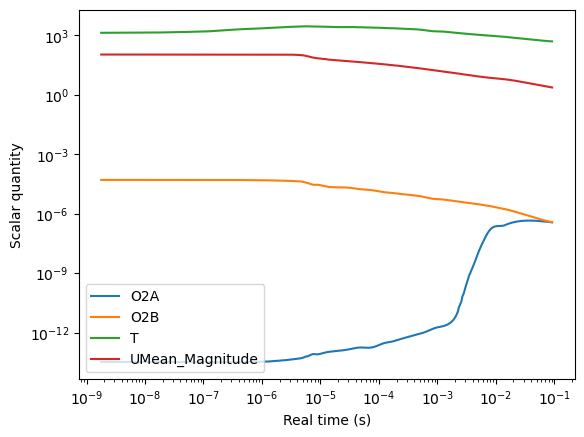

In [1]:
import csv

# Replace 'Streamlines_Test.csv' with your CSV file path
file_path = './case_studies/hetero/Streamline_DFSP_DEG_20_219c8_Test_1.csv'

data_dict = {}

# Open and read the CSV file
with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)  # Reads as dictionaries per row
    for title in csv_reader.fieldnames:
        data_dict[title] = []  # Initialize lists for each column title

    # Populate the dictionary with float values
    for row in csv_reader:
        for title in csv_reader.fieldnames:
            try:
                data_dict[title].append(float(row[title]))
            except:
                continue
print(f'data_dict.keys()  = {data_dict.keys()}')

# Plot key concentration and temperature profiles
import matplotlib.pyplot as plt

plot_keys = ['O2A', 'O2B', 'T', 'UMean_Magnitude']

#NOTE: In KMC use O2A/max(O2A) for better relative concentration estimate
plt.figure()
for key in plot_keys:
    #plt.plot(data_dict['IntegrationTime'], data_dict[key], label=key)
    #plt.semilogy(data_dict['IntegrationTime'], data_dict[key], label=key)
    #plt.semilogy(data_dict['tauCum'], data_dict[key][:-1], label=key)
    #plt.loglog(data_dict['tauCum'], data_dict[key][:-1], label=key)
    plt.loglog(data_dict['tauCum'], data_dict[key][:-2], label=key)
    #plt.plot(data_dict['tauCum'], data_dict[key][:-1], label=key)

plt.ylabel('Scalar quantity')
plt.xlabel('Real time (s)')
plt.legend()


### Deposition based generated film

In [2]:
from classes.particlelayer import *
import numpy as np
import json
import polyscope as ps


file  = './case_studies/hetero/results/hetero.trj'
#file  = './case_studies/hetero/resultshetero.trj'
layer = particlelayer(file, nodescription=False).layer

# Shape
layer._data.shape

# Extract positions in space
points = np.zeros([layer.data.shape[0], 3])
points[:, 0] = layer.data[:, layer.lib['x']]
points[:, 1] = layer.data[:, layer.lib['y']]
points[:, 2] = layer.data[:, layer.lib['z']]
particles = points  # used later
# Extract the radius
radii  = np.zeros(layer.data.shape[0])
radii = layer.data[:, layer.lib['r']]


if 0:
    # Plot in polyscope
    ps.init()
    ps.set_up_dir("z_up")
    ps_cloud = ps.register_point_cloud("Particles", points)
    ps_cloud.add_scalar_quantity("Particle radii", radii)
    ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
    ps_cloud.set_color((1.0, 1.0, 1.0))
    ps.show()


### Reading Particle Structure File
# Filename: ./case_studies/hetero/results/hetero.trj
    File ./case_studies/hetero/results/hetero.trj using units nano and type dda
# File Format: trj
# Units: nano
# Primary Particles: 2,000
# Aggregates: 19
# Box Width: 1.500e+02 x 1.500e+02
# Film Height: 2.974e+02
### Done




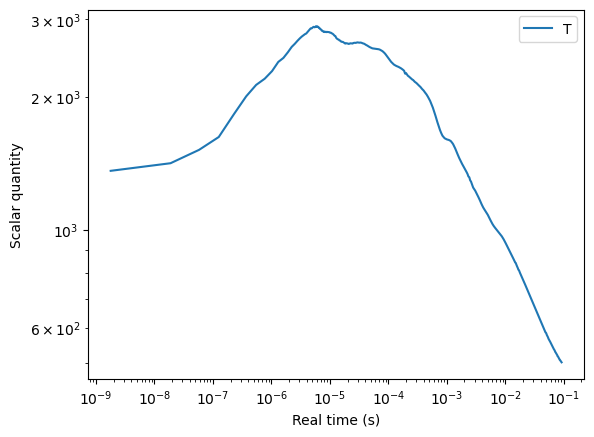

In [3]:
# Plot key concentration and temperature profiles
import matplotlib.pyplot as plt

plt.loglog(data_dict['tauCum'], data_dict['T'][:-2], label='T')


plt.ylabel('Scalar quantity')
plt.xlabel('Real time (s)')
plt.legend()

In [4]:
T = data_dict['T'][:-2]
t_n_start_i = np.argmax(T)
t_n_start_i, len(T)

(45, 725)

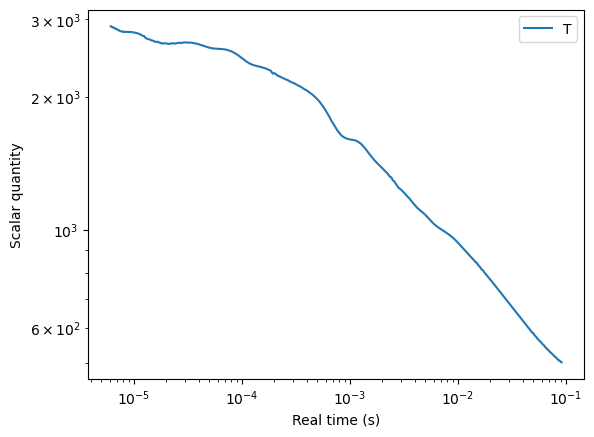

In [5]:
T[t_n_start_i:-2]

plt.figure()
plt.loglog(data_dict['tauCum'][t_n_start_i:], T[t_n_start_i:], label='T')
plt.ylabel('Scalar quantity')
plt.xlabel('Real time (s)')
plt.legend()

## Time discretisation

Here we determine the real time spent available for nucleation

In [6]:
tn = np.array(data_dict['tauCum'][t_n_start_i:]) - np.array(data_dict['tauCum'][t_n_start_i])  # time - starting time
Tn = np.array(T[t_n_start_i:])
CA_n = np.array(data_dict['O2A'][t_n_start_i:-2])
CB_n = np.array(data_dict['O2B'][t_n_start_i:-2])
np.sum(tn), len(tn), len(Tn), len(CA_n), len(CB_n)


(8.820058098604864, 680, 680, 680, 680)

In [7]:
particles.shape[0]/len(tn)

2.9411764705882355

In [8]:
# Assume even split for now (nucleation rates probably based on cooling rate, which is relatively linear?

p_formed = np.zeros_like(tn)  # Number of particles nucleated at every time step
p_formed[:] = int(particles.shape[0]/len(tn)) # Can be modified here later for more realistic distributions.
p_formed[-1] =  particles.shape[0] - np.sum(p_formed[:-1])
p_formed, np.sum(p_formed)

(array([  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   2., 

## KMC rate laws and parameters

In [9]:
# Parameters (to be optimized)
k_A = 1  #  Arrhenius prefactor for compound A
k_B = 1  #  Arrhenius prefactor for compound B
Ea_A = 1  # Activation energy for compound A (should be based on nucleation)
Ea_B = 1  # Activation energy for compound B (should be based on nucleation)

# Parameters (fixed)
n_A = 1  # Rate law order of compound A
n_B = 1  # Rate law order of compound B
R = 8.314  # Universal gas constant J kmol-1 K-1

# Rate law
def r_i(c, T, k, E):
    return k * np.exp(-E / (R * T)) * c

# Reaction rates
r_A_range = r_i(CA_n, Tn, k_A, Ea_A)
r_B_range = r_i(CB_n, Tn, k_B, Ea_A)
r_t = r_A_range + r_B_range

# KMC relative formation rates
ra = r_A_range / r_t
rb = r_B_range / r_t
ra, rb


(array([1.79319154e-09, 1.82894479e-09, 1.87263254e-09, 1.91554574e-09,
        1.96508010e-09, 2.01565508e-09, 2.06636386e-09, 2.11739228e-09,
        2.16596860e-09, 2.21898211e-09, 2.26988433e-09, 2.32226647e-09,
        2.37318378e-09, 2.42938229e-09, 2.48735715e-09, 2.54853085e-09,
        2.60768215e-09, 2.66127269e-09, 2.71327072e-09, 2.75981491e-09,
        2.79986171e-09, 2.82466736e-09, 2.84069591e-09, 2.84729551e-09,
        2.84540362e-09, 2.83940259e-09, 2.82057815e-09, 2.80218877e-09,
        2.77869709e-09, 2.76217435e-09, 2.74804719e-09, 2.74192776e-09,
        2.73556481e-09, 2.73635283e-09, 2.75221720e-09, 2.77093624e-09,
        2.80357830e-09, 2.84048156e-09, 2.88140748e-09, 2.93086387e-09,
        2.98976214e-09, 3.05042178e-09, 3.11447370e-09, 3.18998393e-09,
        3.26515356e-09, 3.34324701e-09, 3.42574130e-09, 3.50689508e-09,
        3.59422875e-09, 3.68001674e-09, 3.76621737e-09, 3.85148505e-09,
        3.94414611e-09, 4.03317394e-09, 4.08011350e-09, 4.323552

### Main nucleation loop

The logic is that each time step we used the KMC rates derived above to find the nucleating particles each time step

In [10]:
particles_A_i = []  # Indices of particle A
particles_B_i = []  # Indices of particle B
# KMC formation each time step
particles_i = 0  # current particle index tracker
for i, pf in enumerate(p_formed):
    for pi in range(int(pf)):
        # Distributed in kmc ration
        if np.random.rand() < ra[i]:
            particles_A_i.append(particles_i)
        else:
            particles_B_i.append(particles_i)

        particles_i += 1  # Current particle index
len(particles_A_i), len(particles_B_i)

(446, 1554)

In [11]:
# Post processing:
Particles_A = particles[particles_A_i]
Particles_B = particles[particles_B_i]
radii_A = radii[particles_A_i]
radii_B = radii[particles_B_i]

In [ ]:
# Plot in polyscope
tab_red = (0.890, 0.102, 0.110)
tab_blue = (0.122, 0.467, 0.706)

ps.init()
ps.set_up_dir("z_up")
ps_cloud_A = ps.register_point_cloud("Particles A", Particles_A)
ps_cloud_A.add_scalar_quantity("Particle A radii", radii_A)
ps_cloud_A.set_color(tab_red)
ps_cloud_B = ps.register_point_cloud("Particles B", Particles_B)
ps_cloud_B.add_scalar_quantity("Particle B radii", radii_B)
ps_cloud_B.set_color(tab_blue)

#ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
ps.show()